In [45]:
import torch 
import matplotlib.pyplot as plt
import copy
from fmfts.experiments.rti3d_sliced.training_parameters import params
from fmfts.dataloader.rti3d_sliced import DatasetSlicedRTI3D
from fmfts.experiments.rti3d_sliced.models import VelocityModelSlicedRTI3D, \
                                                  SingleStepModelSlicedRTI3D, \
                                                  FlowModelSlicedRTI3D

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

velocity = VelocityModelSlicedRTI3D(**params["velocity"]["model_kwargs"])
velocity.load_state_dict(torch.load("trained_models/state_velocity.pt", weights_only=True)["model"])
# single_step = SingleStepModelSlicedRTI3D(velocity_model = copy.deepcopy(velocity), **params["single_step"][])
# single_step.load_state_dict(torch.load("trained_models/state_single_step.pt", weights_only=True)["model"])
# flow = FlowModelSlicedRTI3D(velocity_model = copy.deepcopy(velocity), 
#                             features = params.features_flow)
# flow.load_state_dict(torch.load("trained_models/state_flow.pt", weights_only=True)["model"])

dataset_test = DatasetSlicedRTI3D(mode="test", **params["dataset"]["kwargs"])

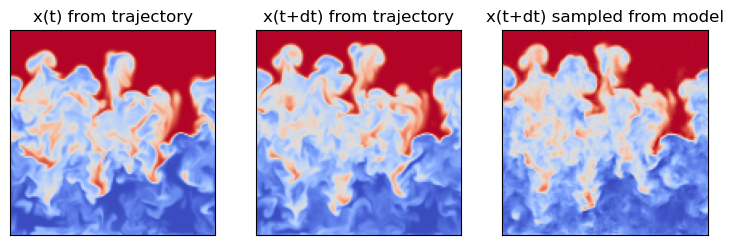

In [46]:
# demonstrates how one can predict a single sample
y, x = dataset_test.get(0, 80, 64, sequence_len=2)
x_pred = velocity.sample(y[None], steps=20, method="midpoint")
# x_pred = single_step.sample(y[None])
# x_pred = flow.sample(y[None], steps=1)

# plotting
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3))
dataset_test.plot(y, ax[0])
dataset_test.plot(x, ax[1])
dataset_test.plot(x_pred, ax[2])
ax[0].set_title("x(t) from trajectory")
ax[1].set_title("x(t+dt) from trajectory")
ax[2].set_title("x(t+dt) sampled from model")
for i in range(3): 
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

torch.Size([14, 5, 128, 128])


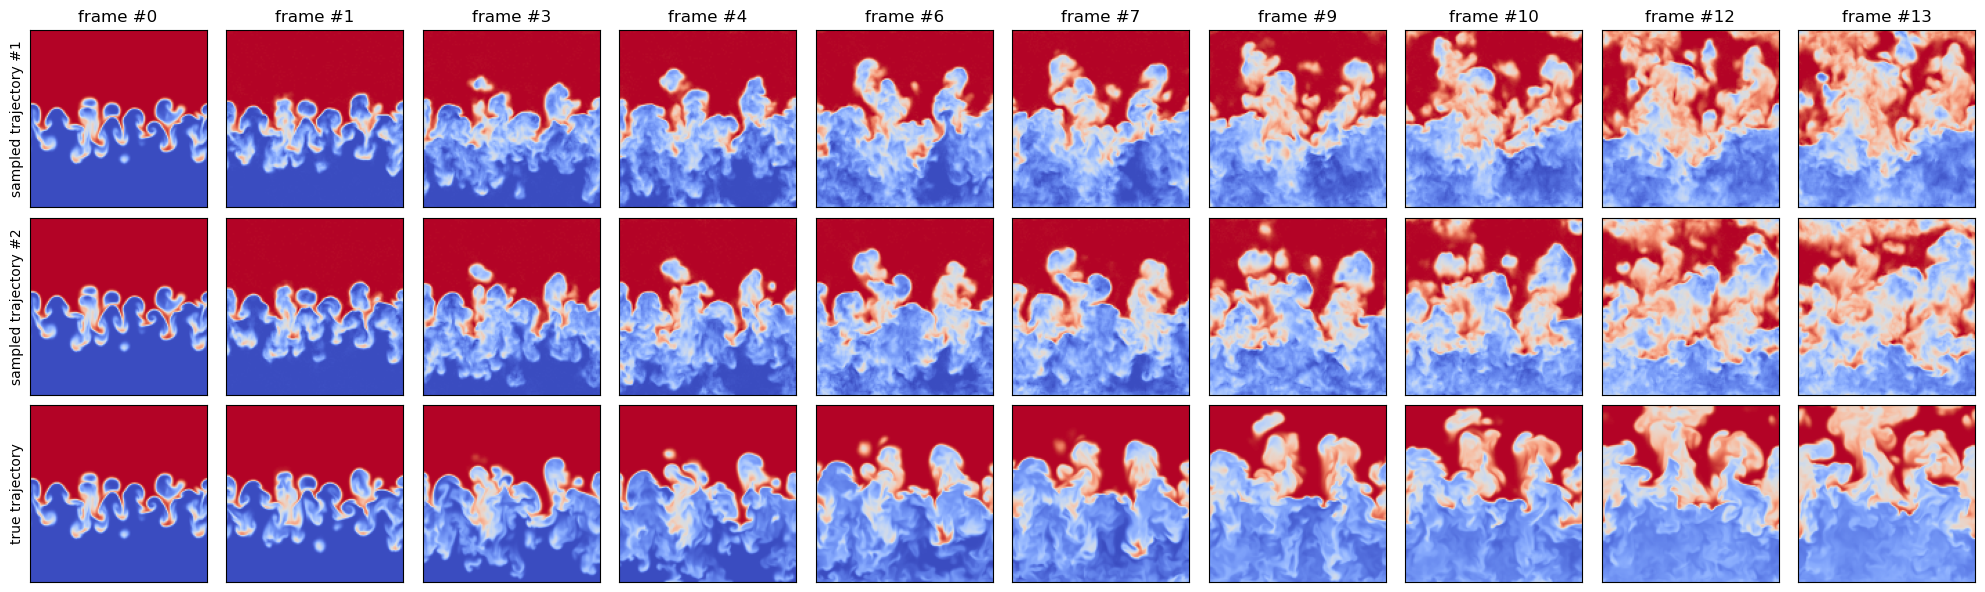

In [34]:
# demonstrates how one can generate multiple trajectories
n_trajectories = 2
n_predictions = 15
y = dataset_test.get(0, 50, 0, sequence_len=n_predictions)
print(y.shape)

xs = torch.empty(n_predictions, n_trajectories, *y.shape[1:])
xs[0,:] = y[0].clone()
for k in range(n_predictions-1):
    # xs[k+1,0,None] = flow.sample(xs[k,0,None], steps=1) 
    xs[k+1,0,None] = velocity.sample(xs[k,0,None], steps=20, method="midpoint") 
    xs[k+1,1,None] = velocity.sample(xs[k,1,None], steps=20, method="midpoint") 
    # xs[k+1] = single_step.sample(xs[k])

# plotting
n_plots   = 10

fig, ax = plt.subplots(n_trajectories + 1, n_plots, figsize=(n_plots*2, (n_trajectories+1)*2))
for k in range(n_trajectories):
    for i in range(n_plots):
        l = i * n_predictions // n_plots
        dataset_test.plot(xs[l, k], ax[k, i])
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
    ax[k,0].set_ylabel(f"sampled trajectory #{k+1}")

for i in range(n_plots):
    l = i * n_predictions // n_plots
    if l < len(y): 
        dataset_test.plot(y[l], ax[-1, i])
        ax[-1, i].set_xticks([])
        ax[-1, i].set_yticks([])
    else:                          
        ax[-1, i].remove()
    ax[0, i].set_title(f"frame #{l}")
ax[-1, 0].set_ylabel("true trajectory")

plt.tight_layout()
plt.show()

Training times:
- single step: 3d on 50% A100 power
- params: 128-196-256
- lr: 1e-4 -- 1e-5
- 10 intermediate steps

- flow: 3d on 50% A100 power
- params: 128-196-256
- lr: 1e-4 -- 1e-5
- 5 intermediate steps